# Evaluate trained LGB model

In [1]:
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import artool
from artool import toy, analyze
from artool.toy.toy_simu import get_pnl_simple, get_pnl_2side
import yaml

from sklearn.metrics import r2_score
import lightgbm as lgb
import shap

# remove limits on number of rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

import matplotlib

#matplotlib.use("Agg")  # use to improve performance
import matplotlib.pyplot as plt
import seaborn as sns


## Config

In [2]:
# Config
config = yaml.safe_load(open("model_0.yaml"))

features = config["features"]
y_feature = config["target"]

res_dir = Path("./model_0")
res_dir.mkdir(exist_ok=True)

model_use = "model_2000"

## Data

In [3]:
data_dir = Path("/home/yangzhe/data/toy_data_2")
date_start = datetime.datetime(2022, 1, 1)
date_end = datetime.datetime(2022, 9, 1)
symbols = toy.toy_data.get_symbol_list(date_start, date_end, logic="and")
print(f"number of symbols: {len(symbols)}")

df = pd.DataFrame()
for symbol in symbols:
    df_ = pd.read_feather(data_dir / f"{symbol}.feather")
    
    # add lagging features
    df_["funding_rate__lag1"] = df_["funding_rate"].shift(1)
    df_["funding_rate__lag3"] = df_["funding_rate"].shift(3)
    df_["funding_rate__lag5"] = df_["funding_rate"].shift(5)

    # add differences
    df_["funding_rate__diff1"] = df_["funding_rate"].shift(1) - df_["funding_rate"]
    df_["funding_rate__diff3"] = df_["funding_rate"].shift(3) - df_["funding_rate"]
    df_["funding_rate__diff5"] = df_["funding_rate"].shift(5) - df_["funding_rate"]

    df_["price_diff"] = df_["mark_price"] - df_["index_price"]

    # remove head/tail 5 rows
    df_ = df_.iloc[5:-5]
    df = pd.concat([df, df_], axis=0)
df = df.reset_index(drop=True)

# Engineer features

## datetime
dt_values = pd.to_datetime(df["funding_timestamp"], unit="us")
df["dt__day_of_week"] = dt_values.dt.dayofweek
df["dt__day_of_month"] = dt_values.dt.day
df["dt__hour"] = dt_values.dt.hour
df["dt__is_quarter_start"] = dt_values.dt.is_quarter_start
df["dt__is_quarter_end"] = dt_values.dt.is_quarter_end
df["dt__is_month_start"] = dt_values.dt.is_month_start
df["dt__is_month_end"] = dt_values.dt.is_month_end
df["dt__is_weekend"] = dt_values.dt.dayofweek >= 5
## extra
df_fear_greed = pd.read_feather("/home/yangzhe/data/external_data/fear_and_greed_index.feather")
df_fear_greed["date"] = pd.to_datetime(df_fear_greed["timestamp"]).dt.date
df_fear_greed["fear_and_greed_value"] = df_fear_greed["fear_and_greed_value"].shift(1)
df_fear_greed["fear_and_greed_class"] = df_fear_greed["fear_and_greed_class"].shift(1)
df["date"] = dt_values.dt.date
df = df.merge(df_fear_greed[["date", "fear_and_greed_value", "fear_and_greed_class"]], on="date", how="left")

number of symbols: 129


In [4]:
#print(list(df.columns))

In [5]:
train_end_date = datetime.datetime(2022, 6, 1)
train_idx = df["funding_timestamp"] < train_end_date.timestamp() * 1e6
test_idx = ~train_idx
df_train = df[train_idx]
df_test = df[test_idx]

## Predict

In [6]:
print(len(features))

109


In [29]:
model_path = Path(f"model_0/{model_use}.txt")
model = lgb.Booster(params=config["params"], model_file=str(model_path))
y_pred_tr = model.predict(df_train[features])
y_pred_te = model.predict(df_test[features])
df_train = df_train.assign(y_pred=y_pred_tr)
df_test = df_test.assign(y_pred=y_pred_te)
y_tr = df_train[y_feature]
y_te = df_test[y_feature]
r2_train = r2_score(y_tr, y_pred_tr)
corr_train = np.corrcoef(y_tr, y_pred_tr)[0, 1]
r2_test = r2_score(y_te, y_pred_te)
corr_test = np.corrcoef(y_te, y_pred_te)[0, 1]

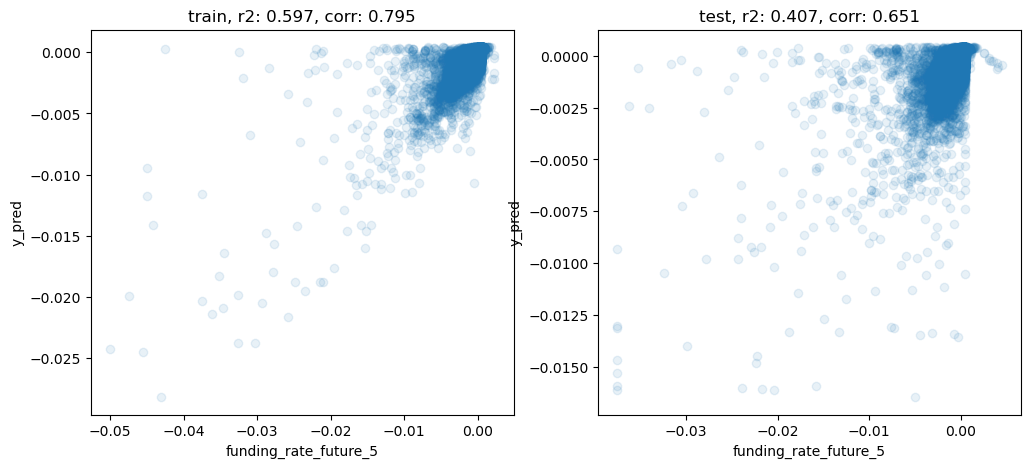

In [8]:
# Plot y_pred vs y_true
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax = np.array(ax)
ax[0].scatter(y_tr, y_pred_tr, alpha=0.1, label="train")
ax[0].set_title(f"train, r2: {r2_train:.3f}, corr: {corr_train:.3f}")
ax[0].set_xlabel("funding_rate_future_5")
ax[0].set_ylabel("y_pred")
ax[1].scatter(y_te, y_pred_te, alpha=0.1, label="test")
ax[1].set_title(f"test, r2: {r2_test:.3f}, corr: {corr_test:.3f}")
ax[1].set_xlabel("funding_rate_future_5")
ax[1].set_ylabel("y_pred")
plt.show()
plt.close(fig)

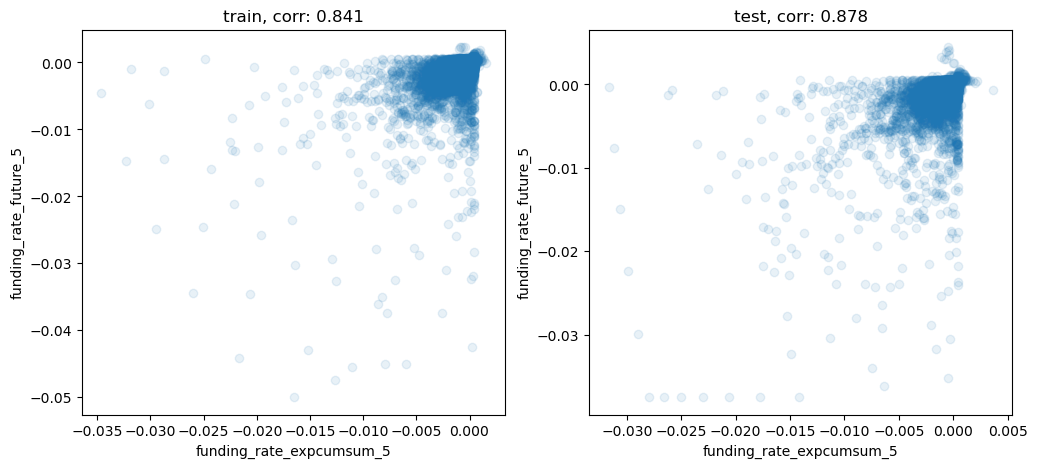

In [30]:
# Plot x vs y_true
xf_tr = df_train["funding_rate_expcumsum_5"]
xf_te = df_test["funding_rate_expcumsum_5"]

corr_train = np.corrcoef(xf_tr, y_pred_tr)[0, 1]
corr_test = np.corrcoef(xf_te, y_pred_te)[0, 1]

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax = np.array(ax)
ax[0].scatter(xf_tr, y_tr, alpha=0.1, label="train")
ax[0].set_title(f"train, corr: {corr_train:.3f}")
ax[0].set_xlabel("funding_rate_expcumsum_5")
ax[0].set_ylabel("funding_rate_future_5")
ax[1].scatter(xf_te, y_te, alpha=0.1, label="test")
ax[1].set_title(f"test, corr: {corr_test:.3f}")
ax[1].set_xlabel("funding_rate_expcumsum_5")
ax[1].set_ylabel("funding_rate_future_5")
plt.show()
plt.close(fig)

## Shap importance

In [9]:
X_tr = df_train[features]
X_te = df_test[features]

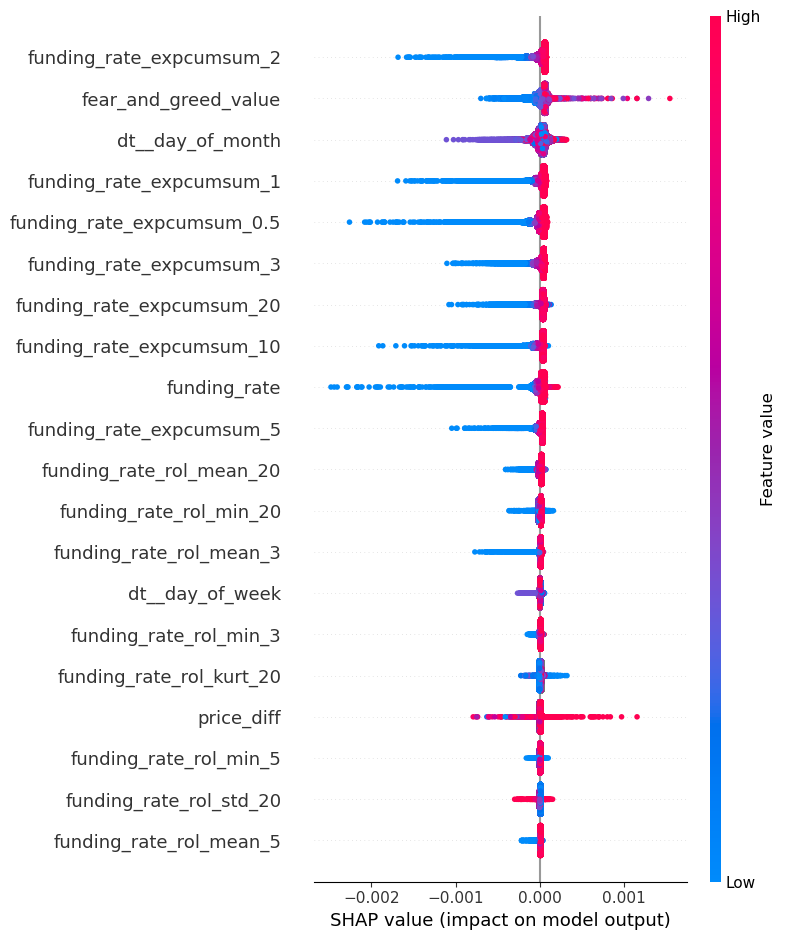

In [20]:
shap_exp = shap.TreeExplainer(model)
#X_sample = X_tr.sample(1000)
X_sample = X_tr
shap_values = shap_exp.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)

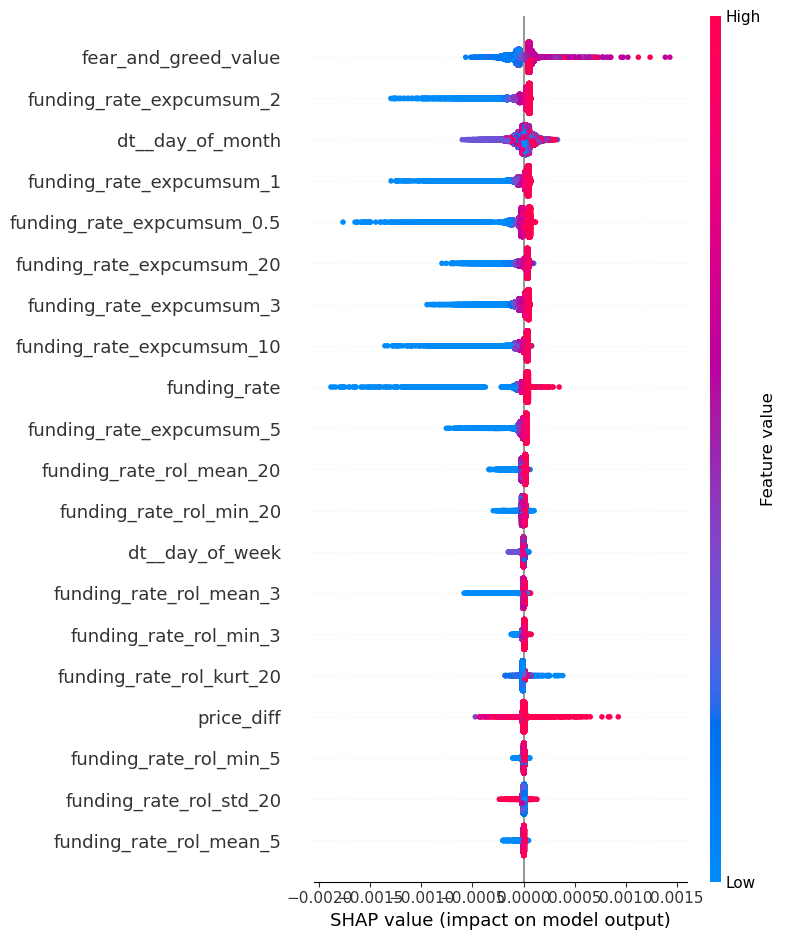

In [21]:
shap_exp = shap.TreeExplainer(model)
#X_sample = X_te.sample(1000)
X_sample = X_te
shap_values = shap_exp.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)

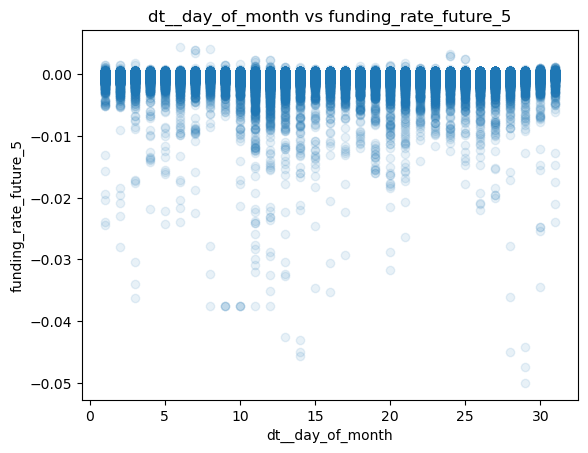

In [23]:
# Plot dt__day_of_month vs y_feature
fig, ax = plt.subplots()
ax.scatter(df["dt__day_of_month"], df[y_feature], alpha=0.1, label="train")
ax.set_title(f"dt__day_of_month vs {y_feature}")
ax.set_xlabel("dt__day_of_month")
ax.set_ylabel(y_feature)
plt.show()
plt.close(fig)

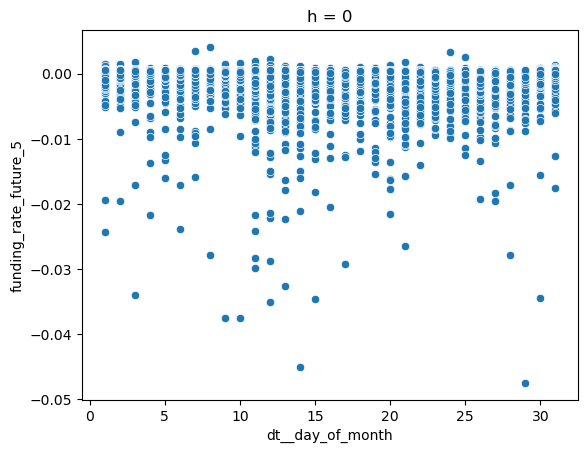

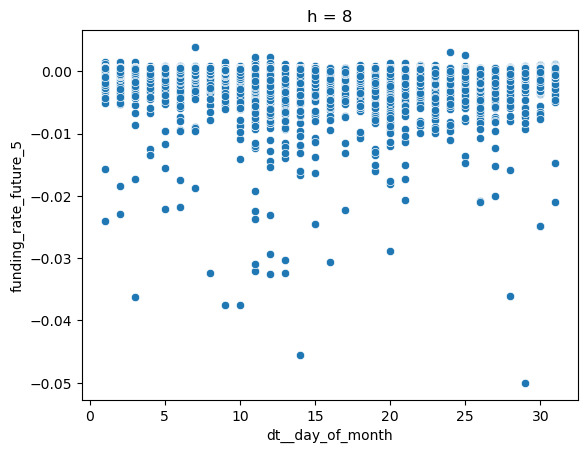

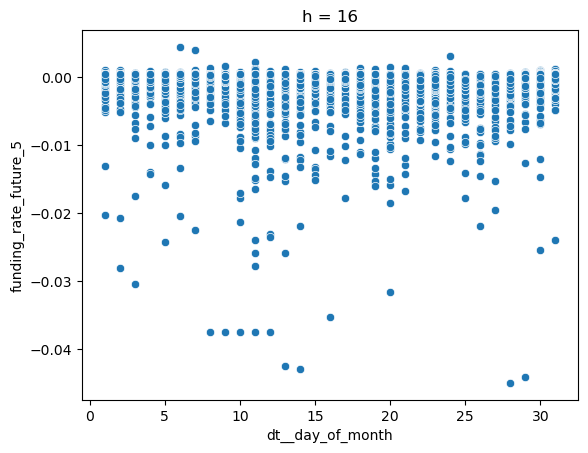

In [26]:
# check hour == 8h, 16h, 24h
for hh in [0, 8, 16]:
    df_hh = df.loc[df["dt__hour"] == hh, ["dt__day_of_month", y_feature]]
    fig, ax = plt.subplots()
    sns.scatterplot(data=df_hh, x="dt__day_of_month", y=y_feature)
    ax.set_title(f"h = {hh}")
    ax.set_xlabel("dt__day_of_month")
    ax.set_ylabel(y_feature)
    fig.savefig(res_dir / f"y_vs_dt_hour{hh}.png")
    fig.show()
    #plt.close(fig)
    

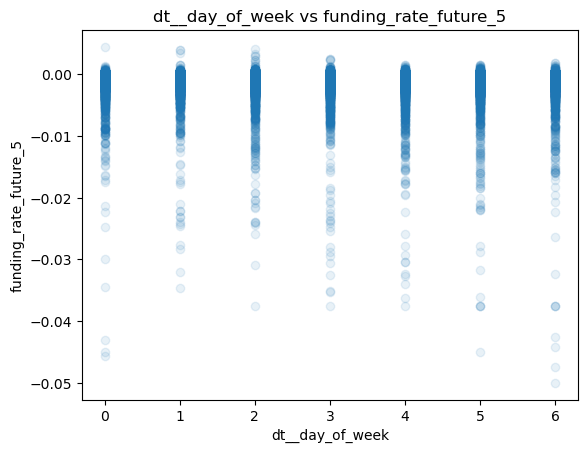

In [25]:
# Plot dt__day_of_week vs y_feature
fig, ax = plt.subplots()
ax.scatter(df["dt__day_of_week"], df[y_feature], alpha=0.1, label="train")
ax.set_title(f"dt__day_of_week vs {y_feature}")
ax.set_xlabel("dt__day_of_week")
ax.set_ylabel(y_feature)
fig.show()

## Default strategy

In [15]:
buy_dim = np.linspace(0, 4e-4, 21)
sell_dim = np.linspace(-8e-4, 0, 41)

In [16]:
# scan buythres and sellthres
dims = {"buythres": buy_dim, "sellthres": sell_dim}


def obj_train(buythres, sellthres):
    total_pnl = 0
    for symbol in symbols:
        y_pred = df_train.loc[df_train["symbol"] == symbol, "y_pred"].values
        fr = df_train.loc[df_train["symbol"] == symbol, "funding_rate"].values
        cur_pnl = get_pnl_simple(
            y_pred, fr, buythres, sellthres
        )
        total_pnl += cur_pnl
    pnl_rate = total_pnl / len(symbols)
    return pnl_rate * 12 / 5


df_scan = artool.analyze.scan.grid_scan(dims, obj_train)

# find optimal buythres and sellthres
df_tmp = df_scan.sort_values(by="score", ascending=False)
best_buy = df_tmp.iloc[0]["buythres"]
best_sell = df_tmp.iloc[0]["sellthres"]
max_agr = df_tmp.iloc[0]["score"]  # max annual growth rate
print(f"best_buy: {best_buy:.6f}, best_sell: {best_sell:.6f}")
print(f"max profit rate per year: {max_agr * 100:.4f} %")
opt_train = {
    "buythres": best_buy,
    "sellthres": best_sell,
    "max_agr": max_agr,
}

# Plot heat map
fig, ax = plt.subplots(figsize=(16, 8))
df_tmp = df_scan.round(6).pivot("buythres", "sellthres", "score")
sns.heatmap(df_tmp, ax=ax)
# add max_agr
ax.set_title(f"max_agr: {max_agr * 100:.4f} %")
fig.savefig(res_dir / "trend_sig.train.png")
plt.close(fig)


100%|██████████| 861/861 [00:35<00:00, 24.25it/s]


best_buy: 0.000160, best_sell: -0.000320
max profit rate per year: 3.5890 %


In [17]:
# scan buythres and sellthres
dims = {"buythres": buy_dim, "sellthres": sell_dim}
def obj_test(buythres, sellthres):
    total_pnl = 0
    for symbol in symbols:
        y_pred = df_test.loc[df_test["symbol"] == symbol, "y_pred"].values
        fr = df_test.loc[df_test["symbol"] == symbol, "funding_rate"].values
        cur_pnl = get_pnl_simple(y_pred, fr, buythres, sellthres)
        total_pnl += cur_pnl
    pnl_rate = total_pnl / len(symbols)
    return pnl_rate * 4
df_scan = artool.analyze.scan.grid_scan(dims, obj_test)

# find optimal buythres and sellthres
df_tmp = df_scan.sort_values(by="score", ascending=False)
best_buy = df_tmp.iloc[0]["buythres"]
best_sell = df_tmp.iloc[0]["sellthres"]
max_agr = df_tmp.iloc[0]["score"]  # max annual growth rate
print(f"best_buy: {best_buy:.6f}, best_sell: {best_sell:.6f}")
print(f"max profit rate per year: {max_agr * 100:.4f} %")
opt_test = {
    "buythres": best_buy,
    "sellthres": best_sell,
    "max_agr": max_agr,
}

# Plot heat map
fig, ax = plt.subplots(figsize=(16, 8))
df_tmp = df_scan.round(6).pivot("buythres", "sellthres", "score")
sns.heatmap(df_tmp, ax=ax)
ax.set_title(f"max_agr: {max_agr * 100:.4f} %")
fig.savefig(res_dir / "trend_sig.test.png")
plt.close(fig)

100%|██████████| 861/861 [00:22<00:00, 38.19it/s]


best_buy: 0.000220, best_sell: -0.000380
max profit rate per year: 1.8693 %


Check optimal difference

In [18]:
agr_tr_opt = obj_test(opt_train["buythres"], opt_train["sellthres"])
agr_diff = (agr_tr_opt - opt_test["max_agr"]) / opt_test["max_agr"]
print(f"agr_diff: {agr_diff * 100:.4f} %")

agr_diff: -3.5997 %


## Use R2 > 0.3

In [19]:
# Get R2_scores for train and test
r2_dict_tr = {}
r2_dict_te = {}
for symbol in symbols:
    # train
    df_tmp = df_train.loc[df_train["symbol"] == symbol]
    y_tr = df_tmp["funding_rate_future_5"].values
    y_pred_tr = df_tmp["y_pred"].values
    r2_tr = r2_score(y_tr, y_pred_tr)
    r2_dict_tr[symbol] = r2_tr
    # test
    df_tmp = df_test.loc[df_test["symbol"] == symbol]
    y_te = df_tmp["funding_rate_future_5"].values
    y_pred_te = df_tmp["y_pred"].values
    r2_te = r2_score(y_te, y_pred_te)
    r2_dict_te[symbol] = r2_te

# Plot train vs test
x_tmp = [r2_dict_tr[symbol] for symbol in symbols]
y_tmp = [r2_dict_te[symbol] for symbol in symbols]
fig, ax = plt.subplots()
ax.scatter(x_tmp, y_tmp)
ax.set_xlabel("R2_score train")
ax.set_ylabel("R2_score test")
ax.set_title("R2_score train vs test")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
fig.savefig(res_dir / "r2_tr_te.png")
plt.close(fig)